In [2]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
from prediction_strength import get_F1_score_per_k

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load Data and True Labels

In [6]:
#----------------------------------------------- DATA ------------------------------------------------------------------
data_dir = "data/"

clear_data = np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")
ambig_data = np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy")
#np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy") #np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")

clear_amplitude_conditions = ["S", "M", "L"]  #["S", "S/M", "M", "M/L", "L"] #["S", "M", "L"]
ambig_amplitude_conditions = ["S", "S/M", "M", "M/L", "L"]

clear_time_constant_conditions = ["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]
ambig_time_constant_conditions = ["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]

#["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]
#["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]

ambiguous_conditions = ["S/M", "M/L", "equal_medium", "wide_medium_negative_skew", "medium_sharp_negative_skew", "medium_wide_positive_skew", "sharp_medium_positive_skew"]

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

ambig_cluster_dict = get_index_per_class(ambig_amplitude_conditions,ambig_time_constant_conditions, ambiguous_conditions, samples_per_condition, samples_per_ambiguous_condition)
clear_cluster_dict = get_index_per_class(clear_amplitude_conditions,clear_time_constant_conditions, [], samples_per_condition, samples_per_ambiguous_condition)


clear_true_labels = get_labels(clear_data, clear_cluster_dict)
ambig_true_labels = get_labels(ambig_data, ambig_cluster_dict)

clear_clusters_ordered = list(range(0,len(clear_cluster_dict)+1))
clear_layout_label_mapping = labels_to_layout_mapping(clear_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))

ambig_clusters_ordered = list(range(0,len(ambig_cluster_dict)+1))
ambig_layout_label_mapping = labels_to_layout_mapping(ambig_clusters_ordered, 9, (2,5))

In [11]:
data = ambig_data
true_labels = ambig_true_labels
layout = ambig_layout_label_mapping
reg = None
k=10

In [5]:
def SSSIM(data,alpha,beta,gamma):
    counter1 = np.outer(np.mean(data, axis = 1),np.mean(data, axis = 1))
    counter2 = np.outer(np.std(data, axis = 1),np.std(data, axis = 1))
    counter3 = np.cov(data,rowvar=True)

    diag1 = counter1.diagonal()
    diag2 = counter2.diagonal()
    denom1 = diag1.reshape((len(diag1),1)) + diag1
    denom2 = diag2.reshape((len(diag2),1)) + diag2

    sim_matrix1 = 2 * counter1 / denom1
    sim_matrix2 = 2 * counter2 / denom2
    sim_matrix3 = (np.round(counter3/counter2,3)+1)/2

    sim_matrix_mu_var = sim_matrix1**alpha * sim_matrix2**beta * sim_matrix3**gamma
    
    return sim_matrix_mu_var

In [7]:
sim_matrix_mu_var = SSSIM(data,1,1,0.1)

In [12]:
from spectral_clustering import calculate_dist_matrix
dist_matrix_euclidean, _ = calculate_dist_matrix(data, "euclidean")

In [17]:
# RAW SSIM (Dice Similarity)
#2xy/(x^2+y^2)
sim_matrix = data @ data.T 
diag = sim_matrix.diagonal()
denom = diag.reshape((len(diag),1)) + diag
sim_matrix = 2 * sim_matrix / denom
dist_matrix_SSIM = 1 - sim_matrix

In [13]:
precomputed_matrix = dist_matrix_euclidean

In [15]:
labels, eigvec, eigval = spectral_clustering(data, "precomputed", "distance", range(1,50), k=k, precomputed_matrix=precomputed_matrix, mutual = False, weighting = False, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Normalization: symmetric
Calculate Eigenvalues and Vectors of Laplacian


In [16]:
np.save("labels_ambig_euclidean_k=10_reg=None",labels)

In [18]:
precomputed_matrix = sim_matrix

In [19]:
labels, eigvec, eigval = spectral_clustering(data, "precomputed", "similarity", range(1,50), k=k, precomputed_matrix=precomputed_matrix, mutual = False, weighting = True, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Similarity of data points!
Weighting: True
Calculate Normalized Laplacians
Normalization: symmetric
Calculate Eigenvalues and Vectors of Laplacian


In [20]:
np.save("labels_ambig_SSIM_RAW_k=10_reg=None_weighted=True",labels)

In [21]:
k=len(data)

In [22]:
labels, eigvec, eigval = spectral_clustering(data, "precomputed", "similarity", range(1,50), k=k, precomputed_matrix=precomputed_matrix, mutual = False, weighting = True, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Similarity of data points!
Weighting: True
Calculate Normalized Laplacians
Normalization: symmetric
Calculate Eigenvalues and Vectors of Laplacian


In [23]:
np.save("labels_ambig_SSIM_RAW_k=Full_reg=None_weighted=True",labels)

## Cluster Balanced Split

In [3]:
clear_train_fold_indices, _ = training_set_split.get_training_folds(clear_data, clear_cluster_dict,cluster_split="balanced",folds = 2)
ambig_train_fold_indices, _ = training_set_split.get_training_folds(ambig_data, ambig_cluster_dict,cluster_split="balanced",folds = 2)


clear_training_set = clear_data[clear_train_fold_indices[0]]
clear_validation_set = clear_data[clear_train_fold_indices[1]]

ambig_training_set = ambig_data[ambig_train_fold_indices[0]]
ambig_validation_set = ambig_data[ambig_train_fold_indices[1]]

clear_true_labels_training = clear_true_labels[clear_train_fold_indices[0]]
clear_true_labels_validation = clear_true_labels[clear_train_fold_indices[1]]

ambig_true_labels_training = ambig_true_labels[ambig_train_fold_indices[0]]
ambig_true_labels_validation = ambig_true_labels[ambig_train_fold_indices[1]]

## Cluster Unbalanced Split

In [4]:
seed = np.random.seed(42)
clear_clusters = np.arange(12)
ambig_clusters = np.arange(45)
np.random.shuffle(clear_clusters)
np.random.shuffle(ambig_clusters)

clear_training_clusters = clear_clusters[0:6]
ambig_training_clusters = ambig_clusters[0:23]

In [ ]:
clear_train_fold_indices, clear_valid_fold_indices = training_set_split.get_training_folds(clear_data, clear_cluster_dict,cluster_split="unbalanced",training_clusters = clear_training_clusters,folds = 2)
ambig_train_fold_indices, ambig_valid_fold_indices = training_set_split.get_training_folds(ambig_data, ambig_cluster_dict,cluster_split="unbalanced",training_clusters = ambig_training_clusters, folds = 2)


clear_training_set = clear_data[clear_train_fold_indices]
clear_validation_set = clear_data[clear_valid_fold_indices]

ambig_training_set = ambig_data[ambig_train_fold_indices]
ambig_validation_set = ambig_data[ambig_train_fold_indices]

clear_true_labels_training = clear_true_labels[clear_train_fold_indices]
clear_true_labels_validation = clear_true_labels[clear_valid_fold_indices]

ambig_true_labels_training = ambig_true_labels[ambig_train_fold_indices]
ambig_true_labels_validation = ambig_true_labels[ambig_valid_fold_indices]

In [ ]:
print(np.unique(clear_true_labels_training,return_counts = True))
print(np.unique(clear_true_labels_validation,return_counts = True))
print(np.unique(ambig_true_labels_training,return_counts = True))
print(np.unique(ambig_true_labels_validation,return_counts = True))

## Prediction strength vs. F1 score 
- True positives: same cluster in  training, same cluster in validation
- False positives: different cluster in training, same cluster in validation
- True negatives: different cluster in training, different cluster in validation
- False negatives: same cluster in training, different cluster in validation 

## Spectral Clustering Configuration 

In [5]:
k = 10
reg = 1

clear_prediction_strength_dir = "Toy_data/Clearly_Separated/Prediction_Strength/"
ambig_prediction_strength_dir = "Toy_data/Ambiguous/Ambiguous_Tau_Amplitude/Prediction_Strength/"

## Load labels
### balanced

In [43]:
clear_training_set_labels = np.load(clear_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_training.npy" % (k, str(reg)))
clear_validation_set_labels = np.load(clear_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_validation.npy" % (k, str(reg)))

ambig_training_set_labels = np.load(ambig_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_training.npy" % (k, str(reg)))
ambig_validation_set_labels = np.load(ambig_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_validation.npy" % (k, str(reg)))

clear_train_labels = {}
clear_valid_labels = {}
for i, labels in enumerate(clear_training_set_labels):
    clear_train_labels[i+1] = labels
    clear_valid_labels[i+1] = clear_validation_set_labels[i]
    
ambig_train_labels = {}
ambig_valid_labels = {}
for i, labels in enumerate(ambig_training_set_labels):
    ambig_train_labels[i+1] = labels
    ambig_valid_labels[i+1] = ambig_validation_set_labels[i]

## F1 Score & Prediction Strength

### Clear Data
- F1 Score
- Prediction Strength

In [ ]:
clear_F1_score_per_k = get_F1_score_per_k(clear_data, clear_train_fold_indices[0], clear_train_fold_indices[1], clear_train_labels, clear_valid_labels, combination_type = "true" ,true_train_labels = clear_true_labels_training)

Calculate F1 score based on true training centroids!


In [ ]:
clear_prediction_strengths_per_k,_ = prediction_strength.get_prediction_strength_per_k(clear_data, clear_train_fold_indices[0], clear_train_fold_indices[1], clear_train_labels, clear_valid_labels, per_sample = False, true_train_labels = clear_true_labels_training)

### Ambiguous Data
- F1 Score
- Prediction Strength

In [32]:
ambig_F1_score_per_k = get_F1_score_per_k(ambig_data, ambig_train_fold_indices[0], ambig_train_fold_indices[1], ambig_train_labels, ambig_valid_labels,combination_type = "true" ,true_train_labels = ambig_true_labels_training)

Calculate F1 score based on true training centroids!


In [ ]:
ambig_prediction_strengths_per_k,_ = prediction_strength.get_prediction_strength_per_k(ambig_data, ambig_train_fold_indices[0], ambig_train_fold_indices[1], ambig_train_labels, ambig_valid_labels, per_sample = False, true_train_labels = ambig_true_labels_training)

### Clear Clustres in Ambiguous Data
- F1 Score
- Prediction Strength

In [33]:
clusters_from_ambig_dataset, counts = np.unique(ambig_true_labels, return_counts = True)

In [34]:
clear_clusters_from_ambig = clusters_from_ambig_dataset[np.where(counts!= 400)]

In [35]:
clear_clusters_from_ambig_idx_validation = np.where(np.isin(ambig_true_labels_validation,clear_clusters_from_ambig) == True)[0]
clear_clusters_from_ambig_idx_training = np.where(np.isin(ambig_true_labels_training,clear_clusters_from_ambig) == True)[0]

In [36]:
ambig_clear_train_inidices = ambig_train_fold_indices[0][clear_clusters_from_ambig_idx_training]
ambig_clear_valid_inidices = ambig_train_fold_indices[1][clear_clusters_from_ambig_idx_validation]

In [37]:
ambig_clear_valid_labels = {}
for i, labels in enumerate(ambig_validation_set_labels):
    ambig_clear_valid_labels[i+1] = labels[clear_clusters_from_ambig_idx_validation]

ambig_clear_true_train_labels = ambig_true_labels_training[clear_clusters_from_ambig_idx_training]    

In [38]:
ambig_F1_score_per_k_clear_clusters = get_F1_score_per_k(ambig_data, ambig_clear_train_inidices, ambig_clear_valid_inidices, None, ambig_clear_valid_labels,combination_type = "true" ,true_train_labels = ambig_clear_true_train_labels)

Calculate F1 score based on true training centroids!


In [ ]:
ambig_prediction_strengths_per_k,_ = prediction_strength.get_prediction_strength_per_k(ambig_data, ambig_clear_train_inidices, ambig_clear_valid_inidices, None, ambig_clear_valid_labels, per_sample = False, true_train_labels = ambig_clear_true_train_labels)

### Comparison of  Clusters for different regularizations

In [4]:
k = 10
regs = [None, 0.01, 0.1, 1, 10] 
clear_prediction_strength_dir = "Toy_data/Clearly_Separated/Prediction_Strength/"
ambig_prediction_strength_dir = "Toy_data/Ambiguous/Ambiguous_Tau_Amplitude/Prediction_Strength/"

In [5]:
data = ambig_data
train_fold_indices = ambig_train_fold_indices[0]
valid_fold_indices = ambig_train_fold_indices[1]
true_labels = ambig_true_labels
true_train_labels = ambig_true_labels_training
true_valid_labels = ambig_true_labels_validation


label_dir = ambig_prediction_strength_dir
save_file = "F1_k=%d_reg=%s_ambig_balanced_true_SSIM_EUCLIDEAN" 

calculate_F1_for_clear_clusters_in_ambig_data = True
save_file_clear_clusters = "F1_clear_clusters_k=%d_reg=%s_ambig_balanced_true_SSIM_EUCLIDEAN" 

In [6]:
for reg in regs:
    
    training_set_labels_i = np.load(label_dir + "Labels/labels_k=%d_reg=%s_SSIM_EUCLIDEAN_training.npy" % (k, str(reg)))
    validation_set_labels_i = np.load(label_dir + "Labels/labels_k=%d_reg=%s_SSIM_EUCLIDEAN_validation.npy" % (k, str(reg)))

    train_labels_dict = {}
    valid_labels_dict = {}
    
    for i, labels in enumerate(training_set_labels_i):
        train_labels_dict[i+1] = labels
        valid_labels_dict[i+1] = validation_set_labels_i[i]
        
    F1_score_per_k_i = get_F1_score_per_k(data, train_fold_indices, valid_fold_indices, train_labels_dict, valid_labels_dict, combination_type = "true" ,true_train_labels = true_train_labels)    
    np.save(save_file % (k,str(reg)), F1_score_per_k_i) 
    
    if calculate_F1_for_clear_clusters_in_ambig_data:
        clusters_from_ambig_dataset, counts = np.unique(true_labels, return_counts = True)
        clear_clusters_from_ambig = clusters_from_ambig_dataset[np.where(counts == 1000)]
        clear_clusters_from_ambig_idx_validation = np.where(np.isin(true_valid_labels,clear_clusters_from_ambig) == True)[0]
        clear_clusters_from_ambig_idx_training = np.where(np.isin(true_train_labels,clear_clusters_from_ambig) == True)[0]

        clear_train_inidices = train_fold_indices[clear_clusters_from_ambig_idx_training]
        clear_valid_inidices = valid_fold_indices[clear_clusters_from_ambig_idx_validation]

        clear_valid_labels_dict = {}
        for i, labels in enumerate(validation_set_labels_i):
            clear_valid_labels_dict[i+1] = labels[clear_clusters_from_ambig_idx_validation]

        clear_true_train_labels = true_train_labels[clear_clusters_from_ambig_idx_training]    
        
        F1_score_per_k_i_clear_clusters = get_F1_score_per_k(data, clear_train_inidices, clear_valid_inidices, None, clear_valid_labels_dict, combination_type = "true" ,true_train_labels = clear_true_train_labels)
        
        np.save(save_file_clear_clusters % (k,str(reg)),F1_score_per_k_i_clear_clusters)

Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!
Calculate F1 score based on true training centroids!


## Plot Mean Prediction Strength vs. F1 Score / F1 Score vs. F1 Score for clear clusters

In [29]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
k=10
configuration = "k=%d - reg=%s" % (k,str(reg))
#save_file = "PS_vs_F1_k=%d_reg=%s_ambig_balanced_true.pdf" % (k,str(reg))
save_file = "F1_clear_clusters_k=%d_reg=%s_ambig_balanced_true.pdf" % (k,str(reg))

In [40]:
#prediction_strengths_per_k = ambig_prediction_strengths_per_k
F1_score_per_k = ambig_F1_score_per_k
F1_score_per_k_clear_clusters = ambig_F1_score_per_k_clear_clusters

In [41]:
fig, ax = plt.subplots(figsize=figsize)

k_clusters = list(F1_score_per_k.keys())

mean_prediction_strengths = []
err_prediction_strengths = []
min_prediction_strengths = []
F1_scores = []
F1_scores_clear_clusters = []

for k in k_clusters:
    #mean_prediction_strengths.append(np.mean(prediction_strengths_per_k[k]))
    #err_prediction_strengths.append(np.std(prediction_strengths_per_k[k]))
    #min_prediction_strengths.append(np.amin(prediction_strengths_per_k[k]))
    F1_scores.append(F1_score_per_k[k])
    F1_scores_clear_clusters.append(F1_score_per_k_clear_clusters[k])


#upper_err = np.asarray(err_prediction_strengths) - np.maximum(0,(np.asarray(err_prediction_strengths)+np.asarray(mean_prediction_strengths)-1))
#lower_err = np.asarray(err_prediction_strengths)
#err = np.stack((lower_err,upper_err), axis=0)

ax.plot(k_clusters, F1_scores, "o-", label="F1-Scores",color = "C0",linewidth=3)
ax.plot(k_clusters, F1_scores_clear_clusters, "o-", label="F1-Scores (Clear Clusters)",color = "C03",linewidth=3)
#ax.plot(k_clusters, mean_prediction_strengths, "o-",label="Mean PS",color = "C0",linewidth=3)
#ax.plot(k_clusters, min_prediction_strengths, "o-", color = "C01", label="Min PS",linewidth=3)

argmax_f1 = np.argmax(F1_scores[1:]) + 1
argmax_f1_clear_clusters = np.argmax(F1_scores_clear_clusters[1:]) + 1
#argmax_mean_ps = np.argmax(mean_prediction_strengths[1:]) +1
#argmax_min_ps = np.argmax(min_prediction_strengths[1:])+1


#if np.abs(argmax_mean_ps-argmax_f1) <8:
if np.abs(argmax_f1_clear_clusters-argmax_f1) <8:
    #if F1_scores[argmax_f1] <= mean_prediction_strengths[argmax_mean_ps]:
    if F1_scores[argmax_f1] <= F1_scores_clear_clusters[argmax_f1_clear_clusters]:
        ps_shift = 0.03
        f1_shift = 0
    else:
        ps_shift = 0
        f1_shift = 0.03
else:
    ps_shift = 0
    f1_shift = 0

#ax.annotate("#%d|Score=%.3f" % (argmax_mean_ps+1, mean_prediction_strengths[argmax_mean_ps]), (k_clusters[argmax_mean_ps] - 1, mean_prediction_strengths[argmax_mean_ps] + 0.03 + ps_shift),fontsize = 16, color = "C0")
ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 + f1_shift), fontsize=16, color = "C0")
ax.annotate("#%d|Score=%.3f" % (argmax_f1_clear_clusters+1, F1_scores_clear_clusters[argmax_f1_clear_clusters]), (k_clusters[argmax_f1_clear_clusters] - 1, F1_scores_clear_clusters[argmax_f1_clear_clusters] + 0.03 + ps_shift),fontsize = 16, color = "C03")
#ax.annotate("#%d|Score=%.3f" % (argmax_min_ps+1, min_prediction_strengths[argmax_min_ps]), (k_clusters[argmax_min_ps] - 1, min_prediction_strengths[argmax_min_ps] + 0.03), fontsize=16, color = "C01")

#title = "Prediction Strength vs. F1-Score for Clustering with k Clusters \n" + configuration 
title = "F1-Score for Clustering with k Clusters \n" + configuration 

ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(fontsize = 14, loc="lower right")

plt.savefig(save_file)
plt.close()

## Plot F1 score for different regularizations 

In [12]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
save_file = "Ambig_F1_clear_clusters_regularization_comparison_None_to_100_k=10_SSIM_EUCLIDEAN.pdf"

In [13]:
k=10
regs = regs = [None, 0.01, 0.1, 1, 10] 
configuration = "SC-Configuration: k=%d" % (k)

In [11]:
product('ABCD', repeat=2)

10


In [14]:
F1_scores_clear_clusters_reg = {}
for reg in regs: 
    f1_dict = np.load("F1_clear_clusters_k=%d_reg=%s_ambig_balanced_true_SSIM_EUCLIDEAN.npy" % (k,str(reg)),allow_pickle=True).item()
    k_clusters = list(f1_dict.keys())
    F1_scores = []
    for i in k_clusters:
        #mean_prediction_strengths.append(np.mean(prediction_strengths_per_k[k]))
        #err_prediction_strengths.append(np.std(prediction_strengths_per_k[k]))
        #min_prediction_strengths.append(np.amin(prediction_strengths_per_k[k]))
        F1_scores.append(f1_dict[i])
    F1_scores_clear_clusters_reg[reg] = F1_scores

In [15]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,50)
for i,reg in enumerate(regs):
    F1_scores = F1_scores_clear_clusters_reg[reg]
    ax.plot(k_clusters, F1_scores, "o-", label="reg=%s" % str(reg),color = "C0%d" % i,linewidth=3)

    argmax_f1 = np.argmax(F1_scores[1:]) + 1

    ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)


title = "F1-Score of Clear Clusters for Clustering with k Clusters \n" + configuration 

ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("F1-Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(fontsize = 14, loc="lower right")

plt.savefig(save_file)
plt.close()

# Plot Clusters

In [35]:
data_dir = "data/"
ambig_data = np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy")
ambig_amplitude_conditions = ["S", "S/M", "M", "M/L", "L"]
ambig_time_constant_conditions = ["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]

ambiguous_conditions = ["S/M", "M/L", "equal_medium", "wide_medium_negative_skew", "medium_sharp_negative_skew", "medium_wide_positive_skew", "sharp_medium_positive_skew"]

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

ambig_cluster_dict = get_index_per_class(ambig_amplitude_conditions,
                                         ambig_time_constant_conditions, 
                                         ambiguous_conditions, 
                                         samples_per_condition, 
                                         samples_per_ambiguous_condition)

ambig_true_labels = get_labels(ambig_data, ambig_cluster_dict)

# Clusters in our dataset
ambig_clusters_ordered = list(range(0,len(ambig_cluster_dict)+1))


# We have 9 clusters for each amplitude and we want them to be plotted in a nice grid format with different
# not overlapping in rows thats why we allocate 2 rows and 5 columns for each amplitude 
ambig_layout_label_mapping = labels_to_layout_mapping(ambig_clusters_ordered, 9, (2,5))

ambig_train_fold_indices, _ = training_set_split.get_training_folds(ambig_data, ambig_cluster_dict,cluster_split="balanced",folds = 2)

ambig_training_set = ambig_data[ambig_train_fold_indices[0]]
ambig_validation_set = ambig_data[ambig_train_fold_indices[1]]


ambig_true_labels_training = ambig_true_labels[ambig_train_fold_indices[0]]
ambig_true_labels_validation = ambig_true_labels[ambig_train_fold_indices[1]]    


k = 10 
reg = 1 
ambig_prediction_strength_dir = "Toy_data/Ambiguous/Ambiguous_Tau_Amplitude/Prediction_Strength/"

ambig_training_set_labels = np.load(ambig_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_training.npy" % (k, str(reg)))
ambig_validation_set_labels = np.load(ambig_prediction_strength_dir + "Labels/labels_k=%d_reg=%s_validation.npy" % (k, str(reg)))

    
ambig_train_labels = {}
ambig_valid_labels = {}
for i, labels in enumerate(ambig_training_set_labels):
    ambig_train_labels[i+1] = labels
    ambig_valid_labels[i+1] = ambig_validation_set_labels[i]
    

    
"""
For Clear Dataset:
rows = 3
columns = 4
figsize = (20,20)
clear_layout_label_mapping = 4, (1,4)
subplot_adjustments = [0.05,0.95,0.03,0.9,0.4, 0.15]
"""

    
k_clusters = 20

save_file_clusters = "F1_clusters_k=%d_reg=%s_ambig_balanced_true_kclusters=%d.pdf" % (k,str(reg),k_clusters)

functions_for_plotting.plot_clusters(ambig_validation_set, # the dataset 
                                     ambig_true_labels[ambig_train_fold_indices[1]], # the true labels for the dataset 
                                     ambig_valid_labels[k_clusters],  # the clustered labels 
                                     10, # the number of rows in the grid 
                                     5, # the number of columns in the grid 
                                     ambig_layout_label_mapping, # our layout mapping 
                                     figsize=(40,30), # the figsize
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= [0.05,0.93,0.02,0.92,0.9, 0.2], # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=False, # plot the mean of each cluster ? 
                                     title= "Validation Set Clusters \n k=%d, $\lambda$=%s" % (k,str(reg))) # title of the plot

NameError: name 'ambig_valid_labels' is not defined

KeyboardInterrupt: 

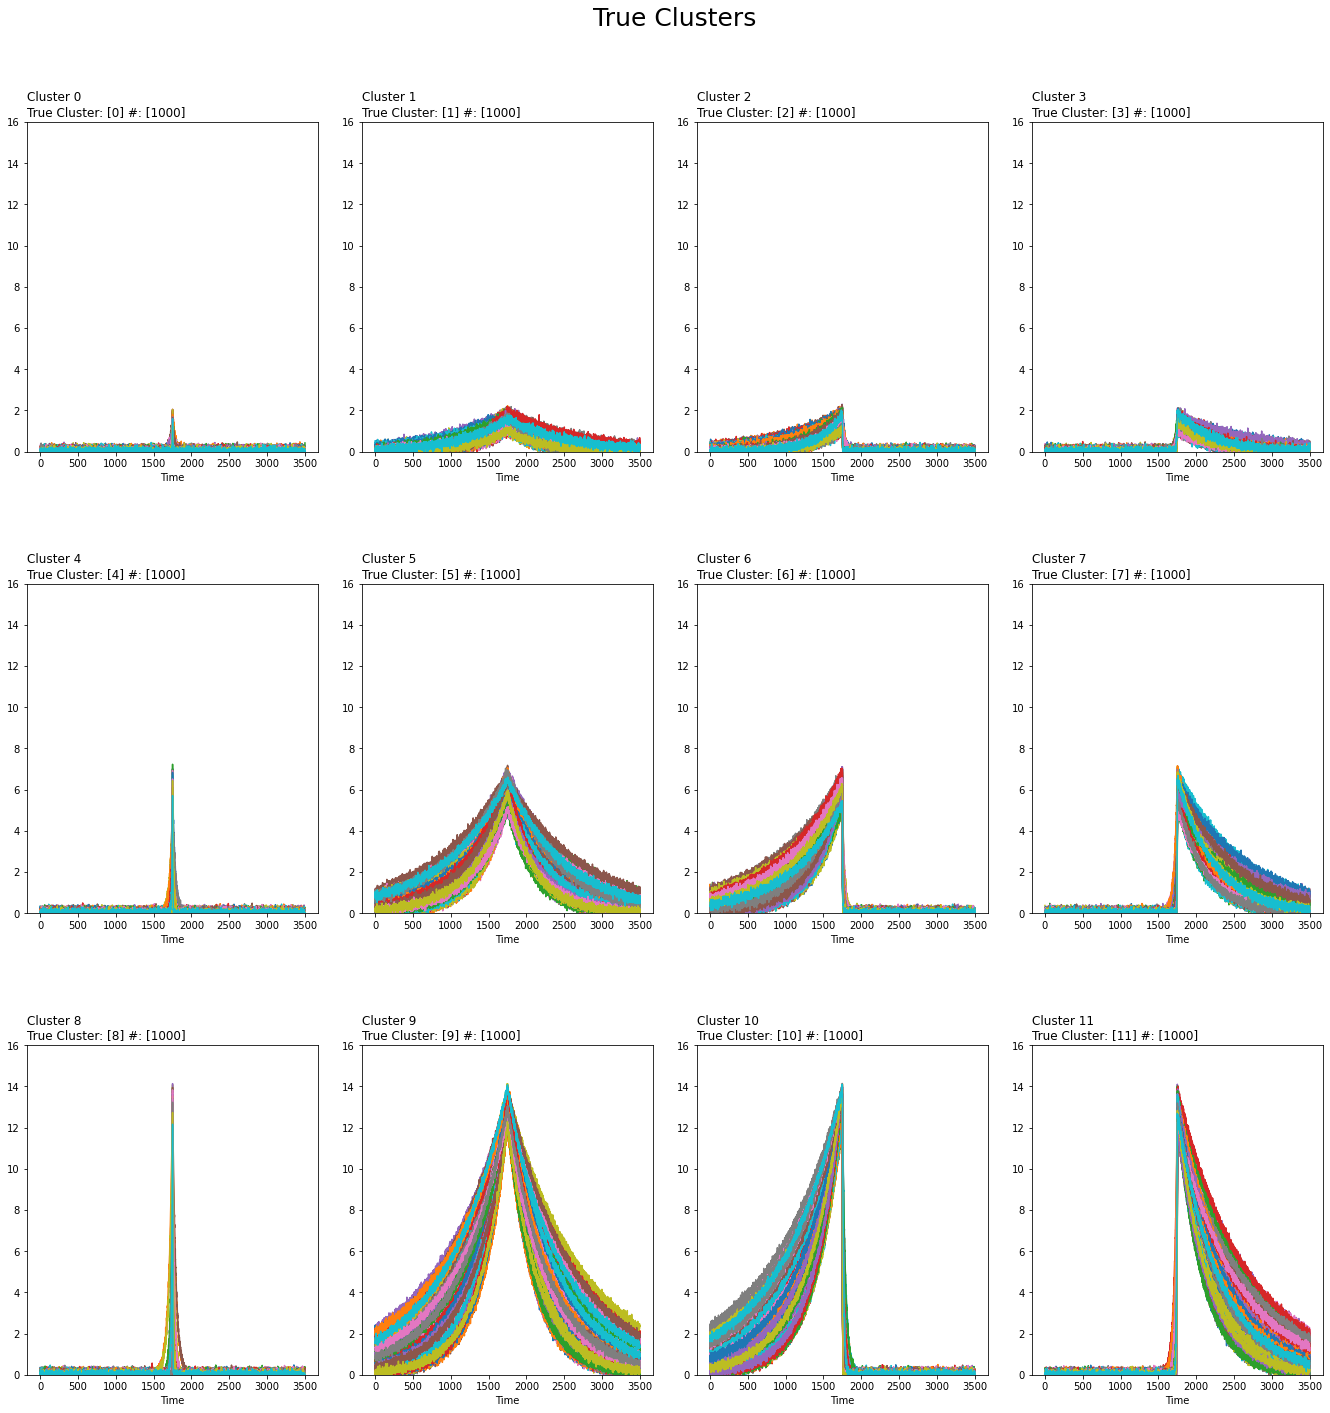

In [4]:
data_dir = "data/"
clear_data = np.load(data_dir + "clearly_separated_data_equal_noise=[0,1]_F_signal_noise.npy")
clear_amplitude_conditions = ["S", "M", "L"]  #["S", "S/M", "M", "M/L", "L"] #["S", "M", "L"]

clear_time_constant_conditions = ["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]

ambiguous_conditions = []

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

clear_cluster_dict = get_index_per_class(clear_amplitude_conditions,clear_time_constant_conditions, [], samples_per_condition, samples_per_ambiguous_condition)

clear_true_labels = get_labels(clear_data, clear_cluster_dict)

clear_clusters_ordered = list(range(0,len(clear_cluster_dict)+1))
clear_layout_label_mapping = labels_to_layout_mapping(clear_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))


save_file_clusters = "true_clusters_equal_noise=[0,1]_mean.pdf"

functions_for_plotting.plot_clusters(clear_data, # the dataset 
                                     clear_true_labels, # the true labels for the dataset 
                                     clear_true_labels,  # the clustered labels 
                                     3, # the number of rows in the grid 
                                     4, # the number of columns in the grid 
                                     clear_layout_label_mapping, # our layout mapping
                                     figsize=(20,20), # the figsize
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= [0.05,0.95,0.03,0.9,0.4, 0.15], # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=True, # plot the mean of each cluster ? 
                                     title= "True Clusters (Mean)" ) # title of the plot


In [ ]:
## Plot Clear Clusters 

In [ ]:
clusters_from_ambig_dataset, counts = np.unique(ambig_true_labels, return_counts = True)
clear_clusters_from_ambig = clusters_from_ambig_dataset[np.where(counts!= 400)]
clear_clusters_from_ambig_idx_validation = np.where(np.isin(ambig_true_labels_validation,clear_clusters_from_ambig) == True)[0]
clear_clusters_from_ambig_idx_training = np.where(np.isin(ambig_true_labels_training,clear_clusters_from_ambig) == True)[0]
ambig_clear_train_inidices = ambig_train_fold_indices[0][clear_clusters_from_ambig_idx_training]
ambig_clear_valid_inidices = ambig_train_fold_indices[1][clear_clusters_from_ambig_idx_validation]
ambig_clear_valid_labels = {}
for i, labels in enumerate(ambig_validation_set_labels):
    ambig_clear_valid_labels[i+1] = labels[clear_clusters_from_ambig_idx_validation]

ambig_clear_true_train_labels = ambig_true_labels_training[clear_clusters_from_ambig_idx_training]    


k = 10 
reg = 0.2
k_clusters = 17
save_file_clusters = "F1_clear_clusters_k=%d_reg=%s_ambig_balanced_true_kclusters=%d.pdf" % (k,str(reg),k_clusters)



functions_for_plotting.plot_clusters(ambig_validation_set[clear_clusters_from_ambig_idx_validation], # the dataset 
                                     ambig_true_labels[ambig_clear_valid_inidices], # the true labels for the dataset 
                                     ambig_clear_valid_labels[k_clusters],  # the clustered labels 
                                     10, # the number of rows in the grid 
                                     5, # the number of columns in the grid 
                                     ambig_layout_label_mapping, # our layout mapping 
                                     figsize=(40,30), # the figsize
                                     n_bursts = 100, # the number of bursts you want to plot for each cluster 
                                     y_lim = (0,16), # the y_lim
                                     save_file=save_file_clusters, # the file you want to save the plot 
                                     subplot_adjustments= [0.05,0.93,0.02,0.92,0.9, 0.2], # adjustments for suplots and overall spacing (tricky) 
                                     plot_mean=False, # plot the mean of each cluster ? 
                                     title= "Validation Set: Clear Clusters \n k=%d, $\lambda$=%s" % (k,str(reg))) # title of the plot